# 4D data processing

In [1]:
# Import all necessary libraries and functions
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
import sys
sys.path.append('../utils')
from functions import *
from plotting import *

In [2]:
# Load the LUNA strain data and convert it to a Numpy array
#The data is in the format of (time samples , gauge number) 

datafile = '../../Data/06-02-23-SigTest_data/test_4.txt'

eps = read_strain(datafile)

if np.isnan(eps).any() == True:
    print("nan here")

<IPython.core.display.Javascript object>


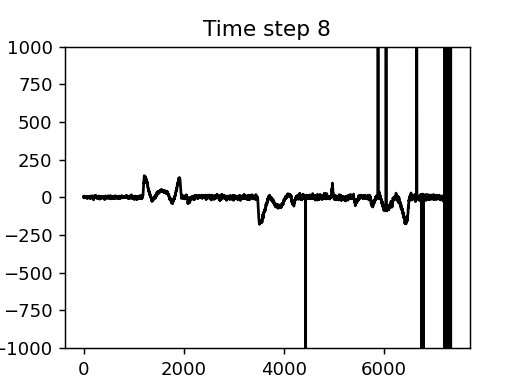

In [3]:
#Plot the raw data
anim = anim_2Dplot(eps, ymin=-1000, ymax=1000, interval=200) 

#f = "plots/raw_test4.gif" 
#writergif = animation.PillowWriter(fps=5) 
#anim.save(f, writer=writergif)

<IPython.core.display.Javascript object>


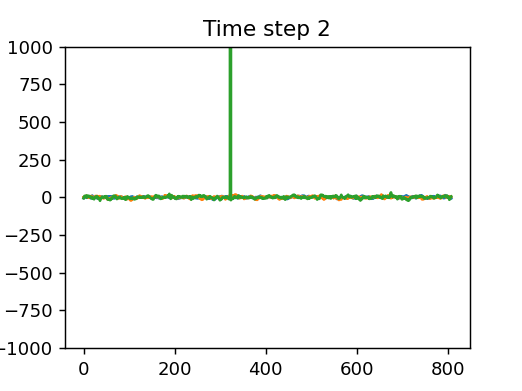

In [10]:
#Isolate sensor cores segments from the raw data
#Currently this needs to be done manually 
dx = 0.0026
length = 2.1
ns = int(length/dx)
nt = eps.shape[0]

#First core
lim1 = 1160
lim2 = lim1 + ns

#Second core
lim3 = lim2 + 1490
lim4 = lim3 + ns

#Third core
lim5 = lim4 + 1455
lim6 = lim5 + ns

#This is the shape of each core array represented by (time samples , number of gauges)
shape = (nt, ns)

#Populate the core arrays
core1 = np.zeros(shape)
core2 = np.zeros(shape)
core3 = np.zeros(shape)

core1 = eps[:,lim1:lim2]
core2 = eps[:,lim3:lim4]
core3 = eps[:,lim5:lim6]

#Plot the data
anim_2Dplot(np.array([core1,core2,core3]), -1000, 1000, 200) 

<IPython.core.display.Javascript object>


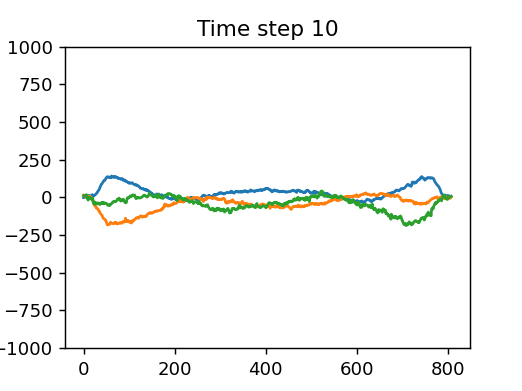

In [11]:
#Remove and interpolate outliers from the data
c1 = reject_outliers(core1, dx=dx, m=0.1)
c2 = reject_outliers(core2, dx=dx, m=0.1)
c3 = reject_outliers(core3, dx=dx, m=0.1)

#Plot the data
anim_2Dplot(np.array([c1,c2,c3]), -1000, 1000, 300) 

<IPython.core.display.Javascript object>


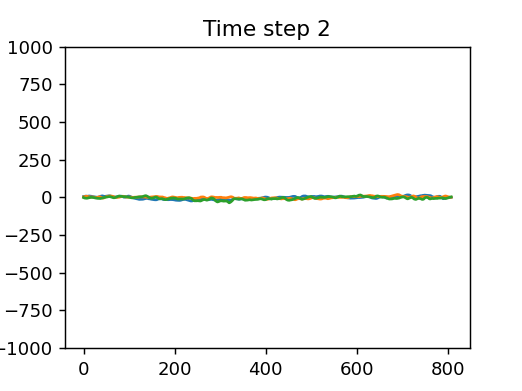

In [9]:
#Smoothen the strain data
sc1, sc2, sc3 = smoothen_strain(np.stack((c1,c2,c3)), kernel_size=10)

#Plot the data
anim = anim_2Dplot(np.array([sc1,sc2,sc3]), -1000, 1000, 500) 
f = "plots/clean-sigday_test4.gif" 
writergif = animation.PillowWriter(fps=5) 
anim.save(f, writer=writergif)

In [10]:
# get ss variables and convert all variables to mm
r_in=8.45                    # r_in is in mm
ds=dx*10**3                    # dx is in m

s=np.stack((sc1, sc2, sc3))   
strain=(s/10**6)           # eps is in microstrain

theta=np.zeros(shape)
K=np.zeros(shape)
phi=np.zeros(shape)
R=np.zeros(shape)
tau=np.zeros(shape)

for i in range(nt):
    theta[i,:], K[i,:], phi[i,:], R[i,:], tau[i,:] = get_ss_var(strain[:,i,:], ds, r_in)
    
#anim = ss_var_aniplot(theta, K, phi, R, tau)

import matplotlib.animation as animation

f = "plots/ss_vairbles-sigday_test4.gif" 
writergif = animation.PillowWriter(fps=5) 
anim.save(f, writer=writergif)

In [8]:
plt.close()

# Initialise path arrays, here we cropped the edges of the sensor where the result is unstable
r_FS=np.zeros((nt, 701, 3))
r_MT=np.zeros((nt, 700, 4))

# provide original frame directions for Frener-Serret method
r_0 = [0,0,0]
N_0 = [1,0,0]                                
T_0 = [0,0,1]

#start = 50
#stop = 750
start = 25
stop = 775
size = stop-start

# Initialise path arrays, here we cropped the edges of the sensor where the result is unstable
r_FS=np.zeros((nt, size+1, 3))
r_MT=np.zeros((nt, size, 4))

# Perform shape sensing using the Frener-Serret and Matrix_Transform methods
for i in range(nt):
    r_FS[i,:,:]=Frenet_Serret(ds, K[i,start:stop], tau[i,start:stop], T_0, N_0, r_0) 
    r_MT[i,:,:] = Matrix_Transform(tau[i,start:stop], R[i,start:stop], phi[i,start:stop], ds)

In [9]:
# compare curve
path_info(r_FS[-1,:], 'true')
path_info(r_MT[-1,:], 'true')

Shape of true (751, 3) with physical length 1949.9690802668933
Shape of true (750, 4) with physical length 1947.3999974345827


In [10]:
rot_FS = np.zeros(r_FS.shape)
rot_MT = np.zeros((r_MT.shape[0],r_MT.shape[1], 3) )

from scipy.spatial.transform import Rotation as R

def rotate_curve(Curve):
    # Extract last point of curve 
    last_point = Curve[-1]
    
    # Define last point constrained at z=0
    rotated_last_point = np.array([last_point[0],last_point[1],0])
    
    # Compute the angle between both vectors
    unit_vector_1 = last_point / np.linalg.norm(last_point)
    unit_vector_2 = rotated_last_point / np.linalg.norm(rotated_last_point)

    dot_product = np.dot(unit_vector_1, unit_vector_2)

    angle = np.arccos(dot_product)
    
    # Rotate the entire curve by the angle
    r = R.from_euler('y',angle)
    rotated_curve = r.apply(Curve)
    
    return rotated_curve

for i in range(nt):
    rot_FS[i,:,:] = rotate_curve(r_FS[i,:,:])
    rot_MT[i,:,:] = rotate_curve(r_MT[i,:,:3])

#transform from millimeter to meters    
rot_FS=rot_FS/10
rot_MT=rot_MT/10


In [11]:
print(rot_FS.shape)

(50, 751, 3)


<IPython.core.display.Javascript object>


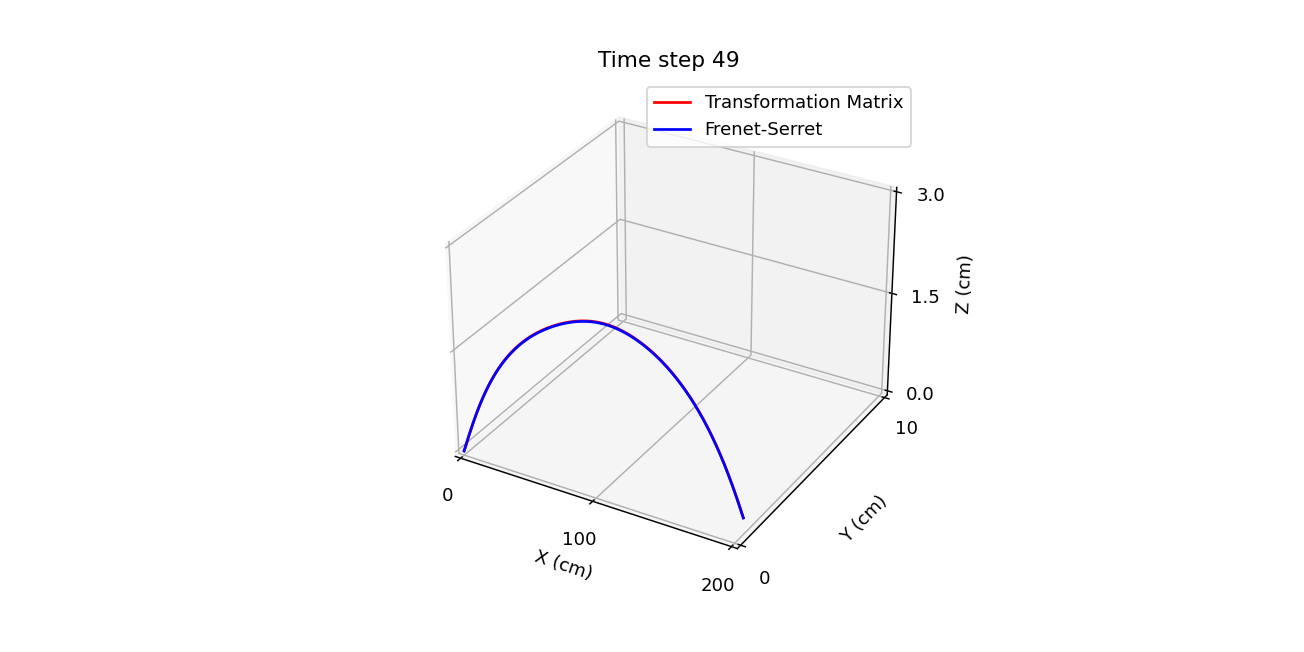

In [12]:
plt.close()
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot(rot_MT[0, :, 0], rot_MT[0, :, 1], rot_MT[0, :, 2], color='r' , label='Transformation Matrix')
line2, = ax.plot(rot_FS[0, :, 0], rot_FS[0, :, 1], rot_FS[0, :, 2], color='b' , label='Frenet-Serret')

def animate(i):
    line.set_data(rot_MT[i,:,0], rot_MT[i,:,1])
    line.set_3d_properties(rot_MT[i,:,2])
    
    line2.set_data(rot_FS[i,:,0],rot_FS[i,:,1])
    line2.set_3d_properties(rot_FS[i,:,2])
    
    ax.set_title('Time step ' + str(i))
    return line, line2,

# Setting the axes properties
ax.set_xlim3d([0, 200])
ax.set_xlabel('X (cm)')
ax.set_xticks((0,100,200))

ax.set_ylim3d([0, 10])
ax.set_ylabel('Y (cm)')
ax.set_yticks((0,10))

ax.set_zlim3d([0, 3])
ax.set_zlabel('Z (cm)')
ax.set_zticks((0,1.5,3))

ax.legend()
#ax.set_aspect('equal', adjustable='datalim', anchor='C')

anim = FuncAnimation(fig, animate, interval=1000, frames=50, repeat=True, blit=True)
plt.show()

f = "plots/path.gif" 
writergif = animation.PillowWriter(fps=1) 
anim.save(f, writer=writergif)

In [13]:
# plot xyz values individually over time
anim=xyzdif_aniplots(rot_FS[:,:-1,:], rot_MT)

f = "plots/xyz_dif.gif" 
writergif = animation.PillowWriter(fps=1) 
anim.save(f, writer=writergif)

<IPython.core.display.Javascript object>